# Preliminaries

Dataset used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [22]:
from pathlib import Path

random_seed = 131313 # for reproducibility
precomputed_rules_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_atomic.data"
precomputed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "Adult" / "rulesAdult_sex_cumulative.data"

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 4.09 s
Wall time: 4.32 s


array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.73      0.62      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



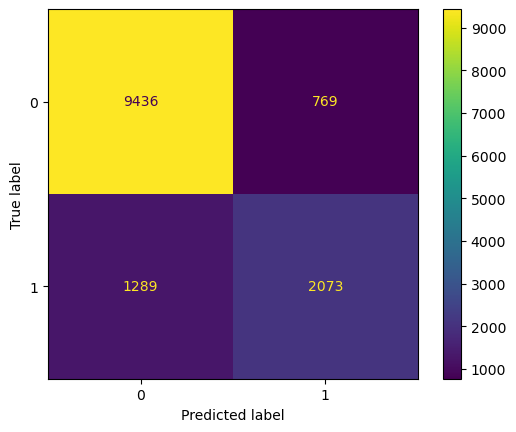

In [9]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and atomic correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [12]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [19]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain", "capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics.

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (34.0, 41.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.28% covered out of 6546
		Make age = (41.0, 50.0], capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 84.97%.
		Aggregate cost of the above recourses = 20.44
	Protected Subgroup ' Female', 2.77% covered out of 4179
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 51.30%.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.44.
If Workclass =  Private, age = (26.0, 34.0], hours-per-week = OverTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.37% covered out of 6546
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 68.48%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relation

### Equal Choice for Recourse

In [20]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.07% covered out of 6546
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 45.83%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 45.83%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 44.44%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 43.06%.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 22.22%.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with effectiveness 29.17%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with effectiveness 43.06%.
		Make hours-per-w

## Micro Viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [ ]:
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

In [23]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

### Equal Effectiveness

### Equal Cost of Effectiveness

### Equal Effectiveness Within Budget

### Fair Effectiveness-Cost Trade-Off